# Mask Attention Visualization Demo

This Demo is a visualization of the attention map of masked words and image regions. 

## Settings

The next two code cells are the settings of model and visualize method. 

We use `rosita-base.pkl` as the default ckpt. You can download [here](https://awma1-my.sharepoint.com/:u:/g/personal/yuz_l0_tn/EYTZaPGm3DRBsbWDSJA8IQMB_-me1J7JAIqyuxzzs1dMyw?download=1) and move to `ckpts/rosita-base.pkl`.

In [ ]:
# -------------------------------------------------------- 
# ROSITA
# Licensed under The Apache License 2.0 [see LICENSE for details] 
# Written by Yuhao Cui and Tong-An Luo
# -------------------------------------------------------- 

# set current work dir
import os
os.chdir('../')
os.getcwd()
# make sure the current work dir is the root 'rosita'.

In [2]:
import sys
sys.path.append('rosita/')
import torch
from rosita.config.cfg import Cfg
from demo_maskatt import Net, DataSet, Visualizer
import matplotlib.pyplot as plt

%matplotlib inline

# set display defaults
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# set config
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
class Arg():
    def __init__(self):
        self.NODE_SIZE = 1
args = Arg()
__C = Cfg(world_size=1, args=args)
__C.CKPT_FILE = 'ckpts/rosita-base.pkl' # we use rosita-base.pkl as the default ckpt
__C.BERT_VOCAB_PATH = 'rosita/utils/bert_vocabs/vocab.txt'
__C.PAD_MAX = {'text': 20, 'image': 36}

# set dataset
dataset = DataSet(__C)

# Load Checkpoint and set model
ckpt_path = __C.CKPT_FILE
ckpt = torch.load(ckpt_path)
init_map = {'vocab_size': dataset.vocab_size}
net = Net(__C, init_map)

net.to('cuda:0')

for weight_key in __C.CKPT_SAVE_MAP:
    if weight_key not in ['net_optim', 'epoch']:
        getattr(net, weight_key).load_state_dict(ckpt[__C.CKPT_SAVE_MAP[weight_key]])

net.eval()

visualizer = Visualizer(dataset, net)


The `show_maskatt_img` function of `Visualizer` is the core for visualization. As stated in our paper, we first extract the multi-head attention maps from the last MSA block of the pretrained model, then perform element-wise addition over different heads to obtain one attention map, and finally visualize the row(s) of specific attention map with respect to different masked token(s).

We provide some paired image-text examples from the MSCOCO validation set to run the following visualizations, which are not used during the pretraining. For each image, we provide pre-extracted `bottom-up-attention` region features (with 36 detected objects). Ecah image is associated with five captions. 

The images are in the `demo/images` folder. Here are the file names of these images:
- COCO_val2014_000000058350.jpg
- COCO_val2014_000000124629.jpg
- COCO_val2014_000000268556.jpg
- COCO_val2014_000000399879.jpg
- COCO_val2014_000000409241.jpg
- COCO_val2014_000000437564.jpg
- COCO_val2014_000000504810.jpg
- COCO_val2014_000000562150.jpg

And their corresponding extracted region features and captions are stored in a `*.jpg.npz` homonymic file in the folder `demo/features`. 

To use `show_maskatt_img`, you need to specify the input `img_name`, which is one of these eight image names, `mask_side` (`'text'` or `'img'`), `mask_id`, a list of masked word/region ids, `text_id` or `text`. 

When masked one word (region), input one masking index in the `mask_id` field, and when masked multiple words (regions), just input a list of masking indices in the `mask_id` field. 

The `text_id` should be within `[0, 4]`, corresponding to one of the five captions of the given image. If you want to provide caption for the image by yourself, you can use the `text` field to input the custom caption.

Before starting, we first introduce some tools to explore the image region features and texts to determinate the key words or key regions to be masked. 

## Show image regions

When you initalized a `Visualizer`, you can use `show_regions` method to visualized the regions of a specify image. The input of the `show_regions` method are the name of the image and region idx list (optional). 

You can check the region idx in the image and decide which region feature to be masked. 

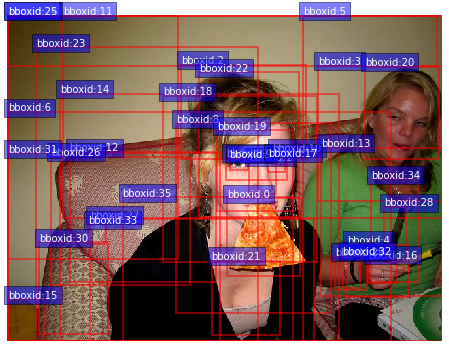

In [3]:
img_name = 'COCO_val2014_000000058350.jpg'
visualizer.show_regions(img_name) # show all regions in the image features

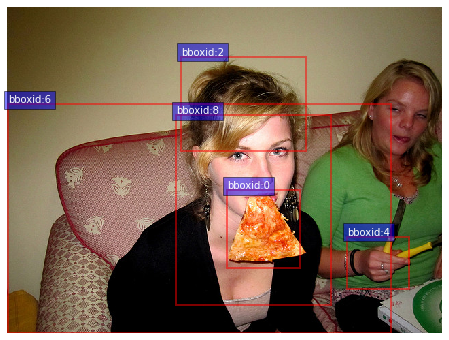

In [4]:
img_name = 'COCO_val2014_000000058350.jpg'
visualizer.show_regions(img_name, [0,2,4,6,8]) # show selected regions by list of idx

## Show text words

Also, you can use `show_words` method to check the words of a specify text. The input of the method is an image name, which indicate the corresponding captions, and a text idx or a custom text. 

You can check the word idx in the text, and decide which word to be masked. 

In [5]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0 # text_id in [0, 1, 2, 3, 4]
visualizer.show_words(img_name, text_id)

word id: 0, word: an
word id: 1, word: older
word id: 2, word: woman
word id: 3, word: standing
word id: 4, word: next
word id: 5, word: to
word id: 6, word: two
word id: 7, word: children


In [6]:
img_name = 'COCO_val2014_000000124629.jpg'
text = "someone's shoes" # using custom text
visualizer.show_words(img_name, text_=text)

word id: 0, word: someone
word id: 1, word: ##s
word id: 2, word: shoes


## Mask One Word

Here are the examples of visualizing attention map when masking one word. 

image_path: demo/images/COCO_val2014_000000124629.jpg
an older |[woman]| standing next to two children


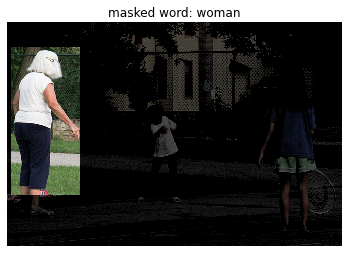

In [7]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0
mask_side = 'text'
mask_id = [2]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000124629.jpg
an older woman standing next to two |[children]|


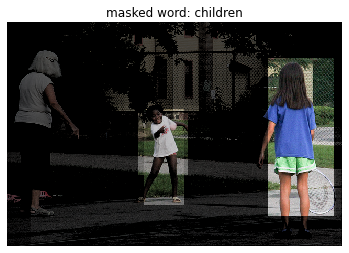

In [8]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0 
mask_side = 'text'
mask_id = [7]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask Multiple Words

Here are the examples of visualizing attention map when masking multiple words. 

The text has multiple masked words, and each masked word has an attention map. 

image_path: demo/images/COCO_val2014_000000124629.jpg
an older |[woman]| standing next to two |[children]|


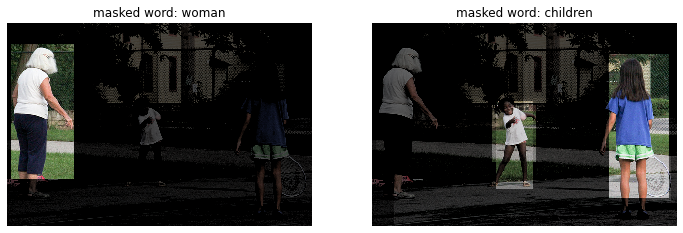

In [9]:
img_name = 'COCO_val2014_000000124629.jpg'
text_id = 0
mask_side = 'text'
mask_id = [2, 7]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000504810.jpg
a large meat |[sandwich]| with a side of |[fries]|


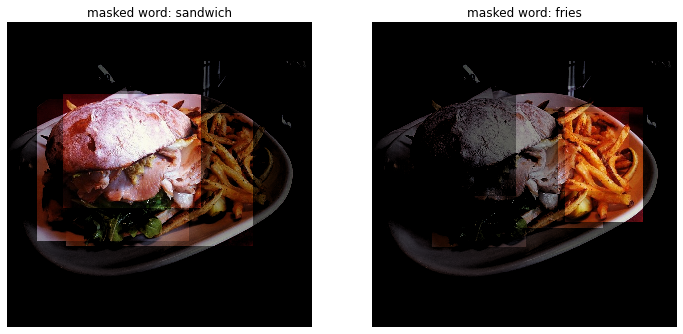

In [10]:
img_name = 'COCO_val2014_000000504810.jpg'
text_id = 1
mask_side = 'text'
mask_id = [3, 8]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000399879.jpg
a |[woman]| is sitting at a |[table]| wearing a robe while a |[man]| is cooking


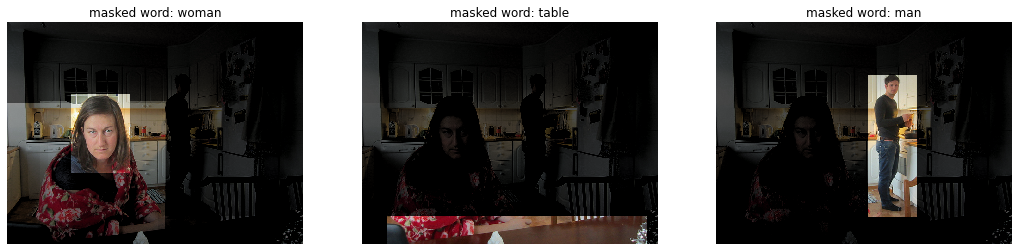

In [11]:
img_name = 'COCO_val2014_000000399879.jpg'
text_id = 3
mask_side = 'text'
mask_id = [1, 6, 12]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask Multiple Words with Custom Text

Here is the example of visualizing attention map when masking multiple words with custom text.

image_path: demo/images/COCO_val2014_000000124629.jpg
a white hair old woman is watching two |[girls]| playing |[tennis]|


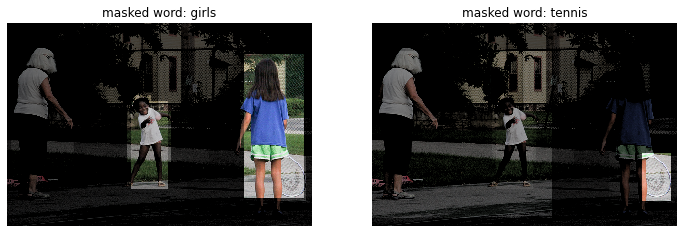

In [12]:
img_name = 'COCO_val2014_000000124629.jpg'
text = 'a white hair old woman is watching two girls playing tennis'
mask_side = 'text'
mask_id = [8, 10]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text=text)

## Mask One Region

Here are the examples of visualizing attention map when masking one region.

image_path: demo/images/COCO_val2014_000000058350.jpg


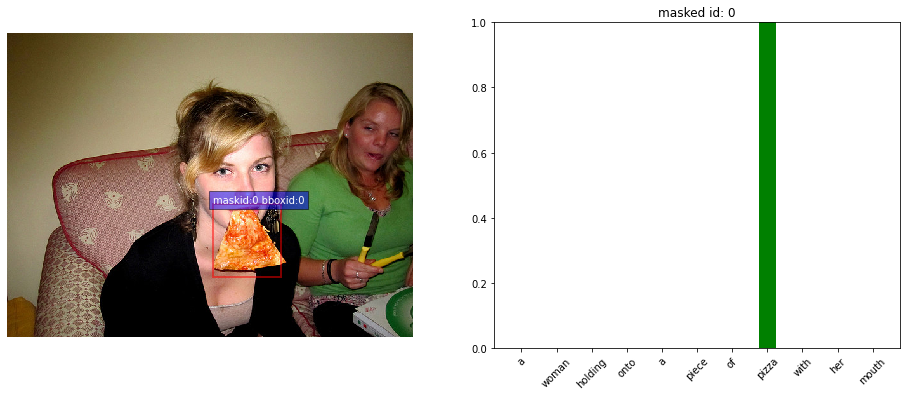

In [13]:
img_name = 'COCO_val2014_000000058350.jpg'
text_id = 3
mask_side = 'img'
mask_id = [0]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000437564.jpg


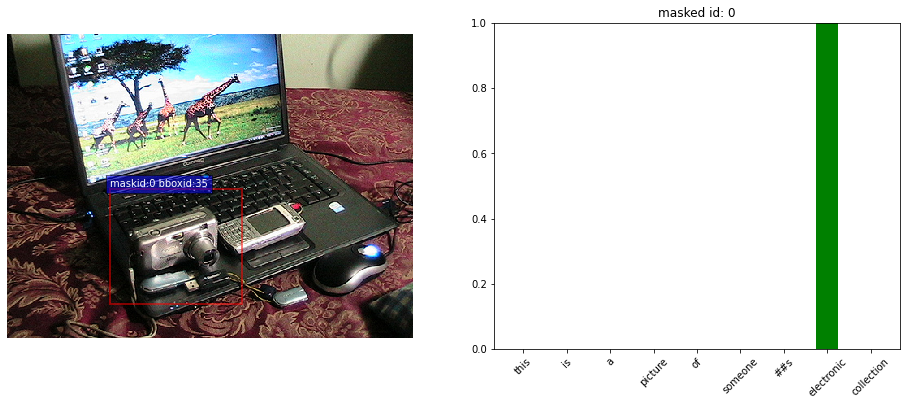

In [14]:
img_name = 'COCO_val2014_000000437564.jpg'
text_id = 1
mask_side = 'img'
mask_id = [35]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask Multiple Regions

Here are the examples of visualizing attention map when masking multiple regions. 

The image feature has multiple masked region features, and each masked region has an attention map of text. 

image_path: demo/images/COCO_val2014_000000562150.jpg


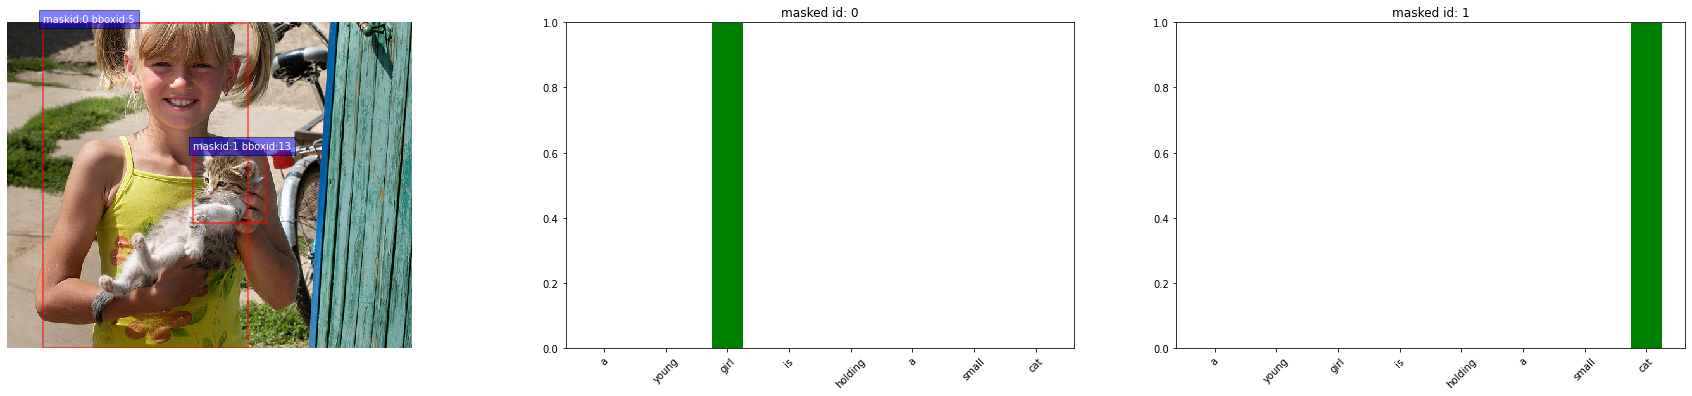

In [15]:
img_name = 'COCO_val2014_000000562150.jpg'
text_id = 2
mask_side = 'img'
mask_id = [5, 13]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

image_path: demo/images/COCO_val2014_000000268556.jpg


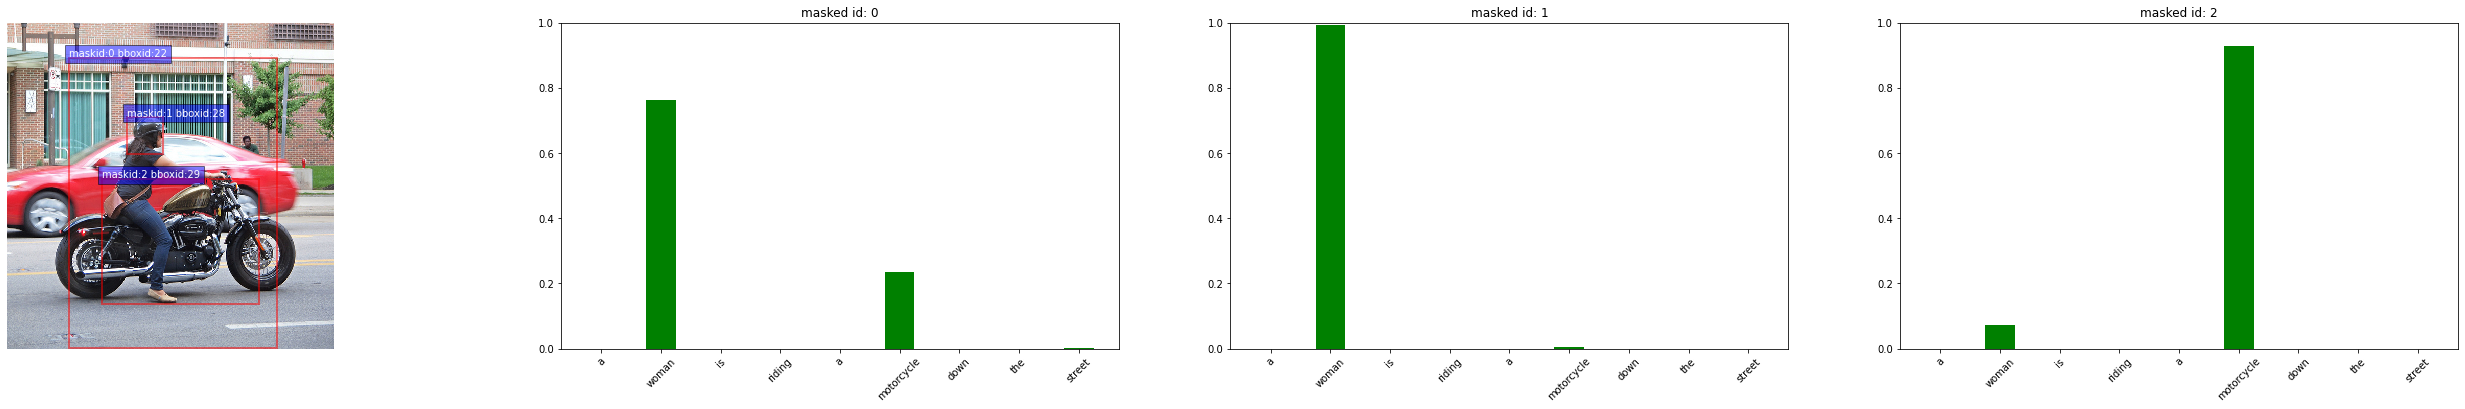

In [16]:
img_name = 'COCO_val2014_000000268556.jpg'
text_id = 0
mask_side = 'img'
mask_id = [22, 28, 29]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text_id)

## Mask Multiple Regions with Custom Text

Here is the example of visualizing attention map when masking multiple regions.

image_path: demo/images/COCO_val2014_000000562150.jpg


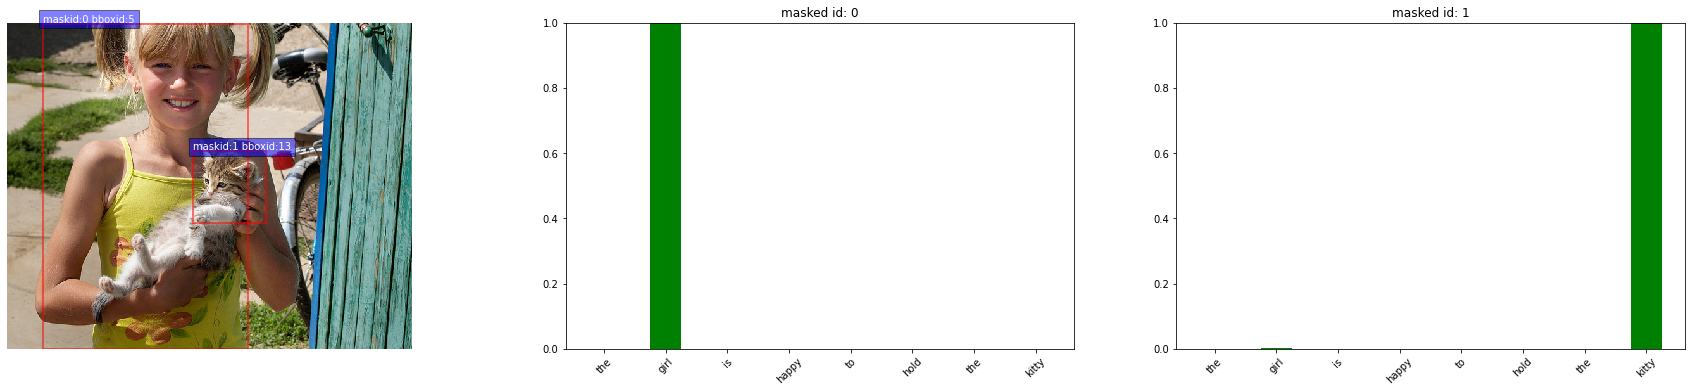

In [17]:
img_name = 'COCO_val2014_000000562150.jpg'
text = 'the girl is happy to hold the kitty'
mask_side = 'img'
mask_id = [5, 13]
visualizer.show_maskatt_img(img_name, mask_side, mask_id, text=text)